# RL for HVAC control with BOPTEST

For this project we are going to train RL agents to control the HVAC system of buildings. We are going to use the Buildnig Optimization Performance Test (BOPTEST) framework to simulate the building and the HVAC system and its gym environment to train the agents.

[BOPTEST](https://ibpsa.github.io/project1-boptest/software/) is a framework that enables evaluation and benchmarking of control algorithms for building HVAC control through simulations. In order to run the simulations we will use the [BOPTEST service](https://github.com/NREL/boptest-service) which is a webservice wrapping the simulation framework. We can use the public instance available at `https://api.boptest.net` (which would be very slow for RL training) or we can host our own one easily with docker by following the instructions on the repo's [`README.md`](https://github.com/NREL/boptest-service?tab=readme-ov-file#building-and-running-on-a-personal-computer)

## 1. Testing the BOPTEST web service

Let's start by testing our local BOPTEST service instance. API documentation can be found [here](https://ibpsa.github.io/project1-boptest/docs-userguide/api.html).

A test case has to be chosen from the [BOPTEST test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html).

In [14]:
import requests
url = 'http://localhost'
testcase = 'bestest_air'

testid = requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']

name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print('Testcase name: ', name, '\n')

inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('Available inputs: ', inputs.keys(), "\n")

measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print('Available measurements: ', measurements.keys(), "\n")

forecast_points = requests.get('{0}/forecast_points/{1}'.format(url, testid)).json()['payload']
print('Available forecast points: ', forecast_points.keys(), "\n")

requests.put('{0}/stop/{1}'.format(url, testid))

Testcase name:  {'name': 'bestest_air'} 

Available inputs:  dict_keys(['con_oveTSetCoo_activate', 'con_oveTSetCoo_u', 'con_oveTSetHea_activate', 'con_oveTSetHea_u', 'fcu_oveFan_activate', 'fcu_oveFan_u', 'fcu_oveTSup_activate', 'fcu_oveTSup_u']) 

Available measurements:  dict_keys(['fcu_reaFloSup_y', 'fcu_reaPCoo_y', 'fcu_reaPFan_y', 'fcu_reaPHea_y', 'zon_reaCO2RooAir_y', 'zon_reaPLig_y', 'zon_reaPPlu_y', 'zon_reaTRooAir_y', 'zon_weaSta_reaWeaCeiHei_y', 'zon_weaSta_reaWeaCloTim_y', 'zon_weaSta_reaWeaHDifHor_y', 'zon_weaSta_reaWeaHDirNor_y', 'zon_weaSta_reaWeaHGloHor_y', 'zon_weaSta_reaWeaHHorIR_y', 'zon_weaSta_reaWeaLat_y', 'zon_weaSta_reaWeaLon_y', 'zon_weaSta_reaWeaNOpa_y', 'zon_weaSta_reaWeaNTot_y', 'zon_weaSta_reaWeaPAtm_y', 'zon_weaSta_reaWeaRelHum_y', 'zon_weaSta_reaWeaSolAlt_y', 'zon_weaSta_reaWeaSolDec_y', 'zon_weaSta_reaWeaSolHouAng_y', 'zon_weaSta_reaWeaSolTim_y', 'zon_weaSta_reaWeaSolZen_y', 'zon_weaSta_reaWeaTBlaSky_y', 'zon_weaSta_reaWeaTDewPoi_y', 'zon_weaSta_reaWeaTDry

<Response [200]>

## 2. Understaing the test case

We'll be working with the `bestest_air` test case. Detailed documentation can be found [here](https://ibpsa.github.io/project1-boptest/docs-testcases/bestest_air/index.html). The provided description is:

> The building is a single room. The floor dimensions are 6m x 8m and the floor-to-ceiling height is 2.7m. There are four exterior walls facing the cardinal directions and a flat roof. The walls facing east-west have the short dimension. The south wall contains two windows, each 3m wide and 2m tall. The use of the building is assumed to be a two-person office with a light load density.     

We also know that the the climate is assumed to be near Denver, CO, USA and that the heating and cooling setpoint follow a schedule. Being it more strict from 8am to 6pm and more relaxed the rest of the time.

Regarding the HVAC system, there is a fan, a cooling coil, a heating coil, and filter. The fan draws room air into the unit, blows it over the coils and through the filter, and supplies the conditioned air back to the room. There is a variable speed drive serving the fan motor. The cooling coil is served by chilled water produced by a chiller and the heating coil is served by hot water produced by a gas boiler. Below is a schematic of the system.

![HVAC system schematic](hvac-schematic-bestest-air.png)

As we already saw from the tests with the API and the documentation, we have a list of available inputs which will be the actions our agent can take. We also have the observations, which are going to be what the agent will use to learn the best actions to take. The observations are both the measurements (the state of the building) and the forecast points (exogenous variables)

> **Exogenous**: Originating or produced from outside a cell, tissue, or organism. *In this case, that it is not affected by the actions taken by the agent i.e. the solar radiation.*

The documentation provides a description for each of the available inputs and observations. We'll start focusing on only a few of them to simplify the problem. 

#### Inputs:

- `fcu_oveTSup_u` [K] [min=285.15, max=313.15]: Supply air temperature setpoint 

#### Outputs:

- `zon_reaTRooAir_y` [K] [min=None, max=None]: Zone air temperature 

Notice that ovbsevations don't have a default min and max values while the inputs do. The user is responsible for choosing the range of values for the observations. We are going to use 318K for the max which is about 45°C and 273K for the min which is equivalent to 0°C.

## 3. Set up the gym environment

We can import the [gym environment](https://github.com/ibpsa/project1-boptest-gym) develpoed by the BOPTEST team and extend the `BoptestGymEnv` class to define our custom reward function.

In [15]:
import os

if not os.path.exists("boptestGymService"):
    !git clone -b boptest-gym-service https://github.com/ibpsa/project1-boptest-gym.git boptestGymService
else:
    print("Folder 'boptestGymService' already exists. Skipping clone.")

import sys
sys.path.insert(0,'boptestGymService')
from boptestGymEnv import BoptestGymEnv

Folder 'boptestGymService' already exists. Skipping clone.


To keep it simple for now we are going to only aim for keeping the user discomfort as low as possible (which means to keep the zone temperature on the desired range) and we are not going to care about energy consumption. The KPIs that BOPTEST provides are, as described in the [API documentation](https://ibpsa.github.io/project1-boptest/docs-userguide/api.html#get-kpi):

```json
    "cost_tot":<value>,     // float, HVAC energy cost in $/m2 or Euro/m2
    "emis_tot":<value>,     // float, HVAC energy emissions in kgCO2e/m2
    "ener_tot":<value>,     // float, HVAC energy total in kWh/m2
    "pele_tot":<value>,     // float, HVAC peak electrical demand in kW/m2
    "pgas_tot":<value>,     // float, HVAC peak gas demand in kW/m2
    "pdih_tot":<value>,     // float, HVAC peak district heating demand in kW/m2
    "idis_tot":<value>,     // float, Indoor air quality discomfort in ppmh/zone
    "tdis_tot":<value>,     // float, Thermal discomfort in Kh/zone
    "time_rat":<value>      // float, Computational time ratio in s/ss
```

For the reward computation we are going to use `tdis_tot`, since as described in the [BOPTEST paper](https://doi.org/10.1080/19401493.2021.1986574) at section 3.4.1: *thermal discomfort defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case*.

To understand how to define a custom reward function it is useful to look at the default implementation of `get_reward` in the `BoptestGymEnv` class. 

In [16]:
class BoptestGymEnvSimpleDiscomfort(BoptestGymEnv):
    
    def get_reward(self):
        kpis = requests.get('{0}/kpi/{1}'.format(self.url,self.testid)).json()['payload']

        objective_integrand = kpis['tdis_tot']
        reward = -(objective_integrand - self.objective_integrand)
        
        self.objective_integrand = objective_integrand
        
        return reward

We need to define some time related parameters before creating the gym env.

- `step_period` [int]: Number of seconds between each step. We are going to use 900 seconds (15 minutes).
- `predictive_period` [int]: Defined the number of steps to predict ahead. This means we will obtain the predicted value for each of the chosen observations for the next `predictive_period` steps. We are going to use 3600 seconds (1 hour or 4 steps).
- `regressive_period` [int]: Defined the number of steps to predict back. The same as `predictive_period` but for the past. We are going to use 3600 seconds (1 hour or 4 steps).
- `max_episode_length` [int]: Maximum number of seconds in an episode. Defines the size of each episode. We are going to use 24 * 3600 seconds (1 day).
- `warmup_period` [int]: How much time do we want the simulation to run before starting the episode. Needs to be at least `regressive_period`. We are going to use 24 * 3600 seconds (1 day).
- `random_start_time` [bool]: If we want to start each episode at a random time. We are going to use `True`.

In [17]:
from boptestGymEnv import BoptestGymEnv, NormalizedObservationWrapper, DiscretizedActionWrapper

env = BoptestGymEnvSimpleDiscomfort(url                  = 'http://localhost',
                    testcase             = 'bestest_air',
                    actions              = ['fcu_oveTSup_u'],
                    observations         = {'zon_reaTRooAir_y':(273.,318.)},
                    predictive_period    = 3600,
                    regressive_period    = 3600,
                    random_start_time    = True,
                    max_episode_length   = 24*3600,
                    warmup_period        = 24*3600,
                    step_period          = 900,
                    render_episodes      = True)

env = NormalizedObservationWrapper(env)
env = DiscretizedActionWrapper(env,n_bins_act=20)

/home/ferran/projects/carles-mateu/a2/.venv/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


<Figure size 640x480 with 0 Axes>

In [18]:
from stable_baselines3 import DQN

model = DQN('MlpPolicy', env, verbose=1, gamma=0.99,
            learning_rate=5e-4, batch_size=64, seed=123456,
            buffer_size=365*24, learning_starts=24, train_freq=1, device='cpu')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
import matplotlib
import warnings
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")
warnings.simplefilter(action='ignore', category=FutureWarning)

def deactivate_plots():
    matplotlib.use('Agg')

def activate_plots():
    %matplotlib inline

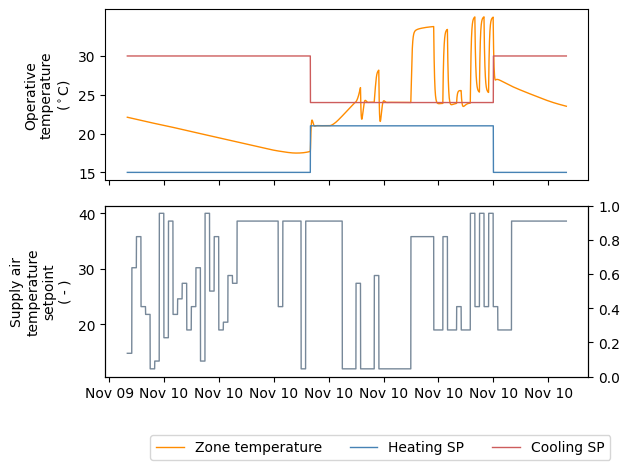

{'tdis_tot': 19.698510774403587, 'idis_tot': 80.16445536347513, 'ener_tot': 0.1705569565772928, 'cost_tot': 0.005866321032657889, 'emis_tot': 0.08083593872411785, 'pele_tot': 0.030198800683771974, 'pgas_tot': 0.053048778066224676, 'pdih_tot': None, 'time_rat': 7.428636885525886e-05}


In [20]:
model.learn(total_timesteps=96 + 95)
print(env.get_kpis())

In [21]:
deactivate_plots()
model.learn(total_timesteps=96 * 90)
activate_plots()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96       |
|    ep_rew_mean      | -26      |
|    exploration_rate | 0.578    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11       |
|    time_elapsed     | 32       |
|    total_timesteps  | 384      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.0472   |
|    n_updates        | 526      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96       |
|    ep_rew_mean      | -18.1    |
|    exploration_rate | 0.156    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12       |
|    time_elapsed     | 61       |
|    total_timesteps  | 768      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.0433   |
|    n_updates      

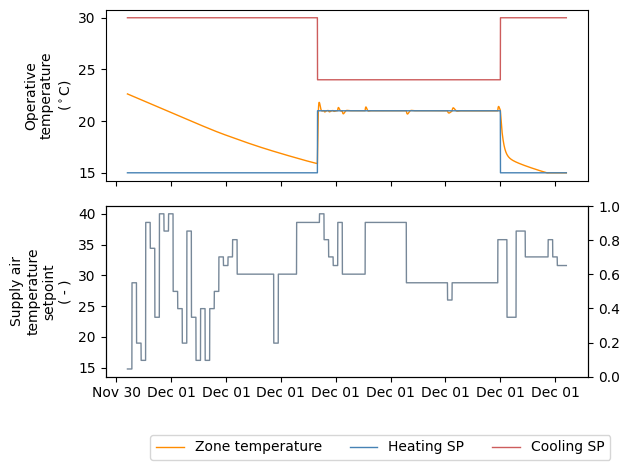

{'tdis_tot': 2.8510598112196486, 'idis_tot': 87.3654346316953, 'ener_tot': 0.12599288535966746, 'cost_tot': 0.005848972893342776, 'emis_tot': 0.07379688323584922, 'pele_tot': 0.026972104397210022, 'pgas_tot': 0.07778258220098638, 'pdih_tot': None, 'time_rat': 5.989492148683783e-05}


In [22]:
model.learn(total_timesteps=96 + 95)
print(env.get_kpis())

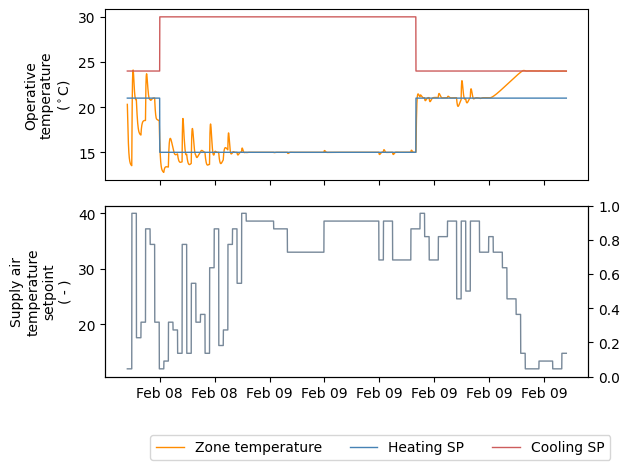

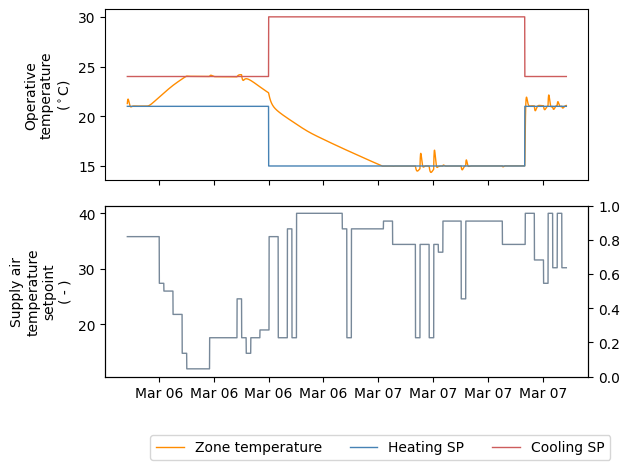

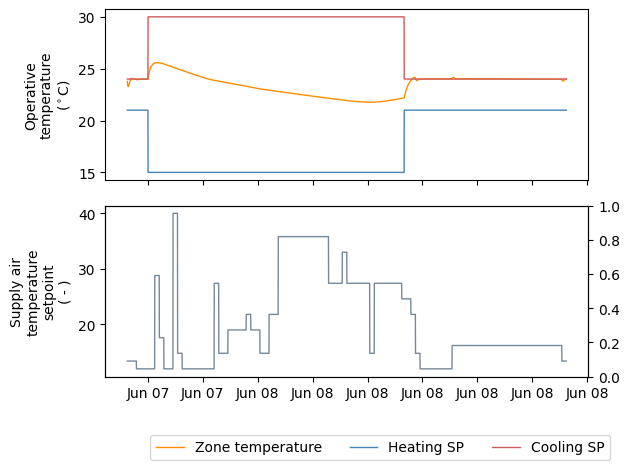

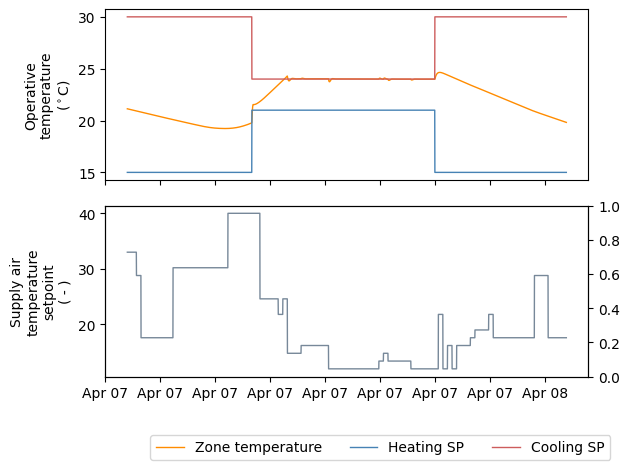

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96       |
|    ep_rew_mean      | -2.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13       |
|    time_elapsed     | 29       |
|    total_timesteps  | 384      |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.00331  |
|    n_updates        | 9309     |
----------------------------------


In [24]:
model.learn(total_timesteps=96 * 4)

# env.stop()

In [25]:
model.save("dqn_bestest_air")

In [26]:
env.stop()